In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Dense, Dropout, Flatten, Lambda, MaxPooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 128

# Datasets
## fashion mnist:
train: 60000 (6000 for each label)

test: 10000 (1000 for each label)
## cifar10
train: 50000 (one label)

test 10000 (one label)

In [17]:
 def read_image_from_url(url, size=(28, 28)):
    image_reader = tf.image.decode_jpeg(
        requests.get(url).content, channels=3, name="jpeg_reader"
    )
    float_caster = tf.cast(image_reader, tf.float32)
    resized = tf.image.resize(float_caster, size=size, method=tf.image.ResizeMethod.BILINEAR, 
                              preserve_aspect_ratio=False, antialias=True)
    gray_image = tf.image.rgb_to_grayscale(
        resized, name=None
    )
    return 1 - tf.cast(gray_image, tf.float32) / 255.

In [18]:
def normalize_fashion_img(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, depth=num_classes)

def normalize_cifar_img(image, label):
    resized = tf.image.resize(image, size=(28, 28), method=tf.image.ResizeMethod.BILINEAR, 
                              preserve_aspect_ratio=False, antialias=True)
    gray_image = tf.image.rgb_to_grayscale(
        resized, name=None
    )
    return tf.cast(gray_image, tf.float32) / 255.,  tf.one_hot(tf.cast(10, dtype=tf.int64), depth=num_classes)

def load_dataset(name, func, split):
    (ds_train, ds_test), ds_info = tfds.load(
        name,
        split=split,
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    ds_train = ds_train.map(
        func, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_test = ds_test.map(
        func, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return ds_train, ds_test, ds_info
    
def prepare_dataset(ds_train, ds_test, total_train_examples):
    # train split
    ds_train = ds_train.shuffle(total_train_examples)
    ds_train = ds_train.cache()
    ds_train = ds_train.batch(BATCH_SIZE)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
    
    # test split
    ds_test = ds_test.cache()
    ds_test = ds_test.batch(BATCH_SIZE)
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
    return ds_train, ds_test

In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']#, 'None of them']
num_classes = len(class_names)

fashion_train, fashion_test, fashion_info = load_dataset('fashion_mnist', normalize_fashion_img, ['train', 'test'])
cifar_train, cifar_test, cifar_info = load_dataset('cifar10', normalize_cifar_img, ['train[:100%]', 'test[:100%]'])

ds_train = fashion_train#.concatenate(cifar_train)
ds_test = fashion_test#.concatenate(cifar_test)
total_train_examples = fashion_info.splits['train'].num_examples# + cifar_info.splits['train'].num_examples 


ds_train, ds_test = prepare_dataset(ds_train, ds_test, total_train_examples)



In [20]:
def print_next_example(dataset):
    data_row = next(iter(dataset))
    img = data_row[0]
    label = data_row[1]
    for i in range(2):
        plt.imshow(img[i])
        plt.show()
        print(class_names[np.argmax(label[i].numpy())])

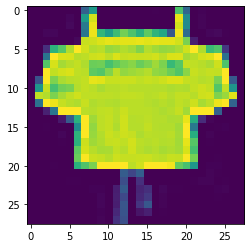

Shirt


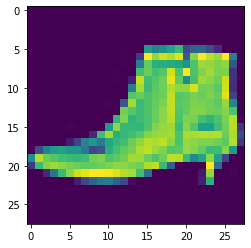

Ankle boot


In [21]:
print_next_example(ds_train)


In [22]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (1-x)
    else:
        x
    return x

data_augmentation = tf.keras.Sequential([
  Lambda(lambda x: random_invert_img(x, 0.5)),
])

In [34]:
def model():
    cnn1 = Sequential()
    cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    cnn1.add(Dropout(0.2))
    
    cnn1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    cnn1.add(Dropout(0.4))

    cnn1.add(Flatten())

    cnn1.add(Dense(64, activation='relu'))
    cnn1.add(Dense(num_classes, activation='softmax'))
    cnn1.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics='accuracy')
    return cnn1

In [35]:
model = model()

In [36]:
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
) 

Epoch 1/10
235/235 [==============================] - 21s 88ms/step - loss: 1.0440 - accuracy: 0.6302 - val_loss: 0.4971 - val_accuracy: 0.8118
Epoch 2/10
235/235 [==============================] - 24s 100ms/step - loss: 0.4797 - accuracy: 0.8230 - val_loss: 0.4132 - val_accuracy: 0.8530
Epoch 3/10
235/235 [==============================] - 25s 106ms/step - loss: 0.4163 - accuracy: 0.8492 - val_loss: 0.3893 - val_accuracy: 0.8602
Epoch 4/10
235/235 [==============================] - 26s 111ms/step - loss: 0.3843 - accuracy: 0.8615 - val_loss: 0.3602 - val_accuracy: 0.8700
Epoch 5/10
235/235 [==============================] - 30s 126ms/step - loss: 0.3535 - accuracy: 0.8705 - val_loss: 0.3420 - val_accuracy: 0.8764
Epoch 6/10
235/235 [==============================] - 24s 102ms/step - loss: 0.3366 - accuracy: 0.8758 - val_loss: 0.3181 - val_accuracy: 0.8863
Epoch 7/10
235/235 [==============================] - 23s 96ms/step - loss: 0.3179 - accuracy: 0.8840 - val_loss: 0.3032 - val_accu

In [37]:
model.save('../resources/fashion')

INFO:tensorflow:Assets written to: ../resources/fashion/assets


INFO:tensorflow:Assets written to: ../resources/fashion/assets


In [38]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print('\nTest accuracy:', test_acc)

40/40 - 1s - loss: 0.2909 - accuracy: 0.8951

Test accuracy: 0.8950999975204468


In [39]:
model = tf.keras.models.load_model('../resources/fashion')

In [40]:
urls = [
    "https://img01.ztat.net/article/spp-media-p1/2f0f3b276e73332f84a9ef365b14c942/777754c250624c2eaadbb006e647f6e8.jpg",
    'https://media.loropiana.com/HYBRIS/FAI/FAI2107/C983A228-A47F-43EC-8776-1DBB123ACE41/FAI2107_B0PJ_MEDIUM.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/8/89/Totebag.jpg',
    'https://martinvalen.com/12753-large_default/stone-black-trousers-with-white-stripes-and-chain.jpg',
    'https://loudresses.com/eng_il_Nevada-A-Dress-in-a-shade-of-beige-made-of-pleasant-to-the-touch-fabric-678.jpg',
    'https://upload.wikimedia.org/wikipedia/en/d/d5/1979_Alien_Design.jpg',
]

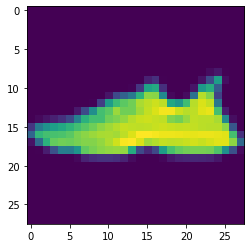

{'Sneaker': 0.927523, 'Sandal': 0.05530512, 'Ankle boot': 0.015182643, 'Bag': 0.0017065518, 'T-shirt/top': 0.000200941, 'Dress': 4.4518656e-05, 'Pullover': 2.2406168e-05, 'Shirt': 8.949942e-06, 'Trouser': 5.112612e-06, 'Coat': 6.60912e-07}
Sneaker


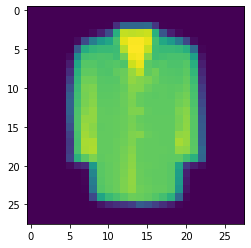

{'Coat': 0.695948, 'Pullover': 0.18387988, 'Shirt': 0.06297891, 'Bag': 0.029767951, 'T-shirt/top': 0.013226198, 'Dress': 0.012425843, 'Sneaker': 0.0008868894, 'Trouser': 0.00057737913, 'Sandal': 0.00017726661, 'Ankle boot': 0.0001316904}
Coat


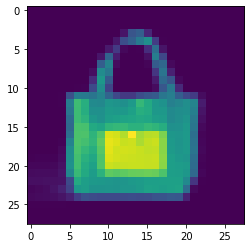

{'Bag': 0.5805603, 'Pullover': 0.24419826, 'T-shirt/top': 0.121046394, 'Shirt': 0.035675593, 'Dress': 0.0059230984, 'Trouser': 0.0034243523, 'Ankle boot': 0.0032706447, 'Sneaker': 0.0030806724, 'Coat': 0.0023568051, 'Sandal': 0.00046387693}
Bag


{'Trouser': 0.90641165, 'Bag': 0.034051344, 'T-shirt/top': 0.026354376, 'Shirt': 0.012644609, 'Pullover': 0.009073179, 'Ankle boot': 0.008422202, 'Dress': 0.0011426437, 'Sneaker': 0.0010533803, 'Coat': 0.0005310684, 'Sandal': 0.0003154229}
Trouser


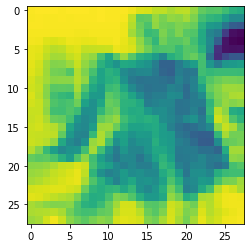

{'Pullover': 0.28093487, 'T-shirt/top': 0.17550181, 'Bag': 0.16210812, 'Shirt': 0.15468624, 'Dress': 0.09831553, 'Ankle boot': 0.08398771, 'Coat': 0.014492738, 'Trouser': 0.010773576, 'Sneaker': 0.010583717, 'Sandal': 0.008615676}
Pullover


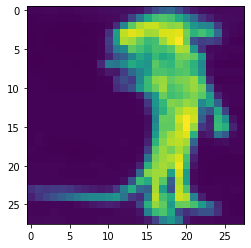

{'Sandal': 0.38473248, 'Ankle boot': 0.2330216, 'Sneaker': 0.12133199, 'Trouser': 0.10640992, 'T-shirt/top': 0.08771921, 'Pullover': 0.031170122, 'Bag': 0.024375265, 'Shirt': 0.007819286, 'Coat': 0.0021678281, 'Dress': 0.0012522644}
Sandal


In [41]:
for url in urls:
    gray_im = read_image_from_url(url)
    plt.imshow(gray_im)
    plt.show()
    new_img = (np.expand_dims(gray_im,0))
    predictions_single = model.predict(new_img)
    preds = dict(zip(class_names, predictions_single[0]))
    print({k: v for k, v in sorted(preds.items(), key=lambda item: item[1], reverse=True)})
    print(class_names[np.argmax(predictions_single[0])])